Number of training samples: 333
Number of validation samples: 84
Classes: ['choose_words', 'fill_blank', 'select_meaning', 'type_sentence']


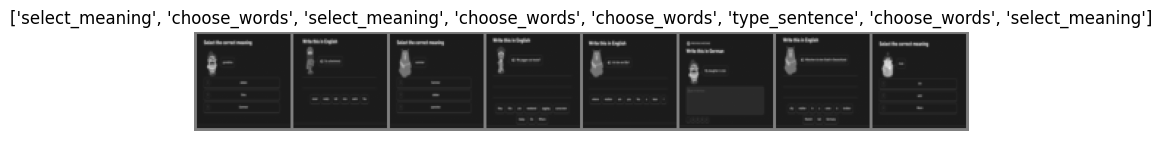

In [ ]:
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), 
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  
])


dataset = datasets.ImageFolder(root='training_data', transform=transform)


train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])


train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
print("Number of training samples:", len(train_dataset))
print("Number of validation samples:", len(val_dataset))

print("Classes:", dataset.classes)


def imshow(img, title):
    img = img * 0.5 + 0.5  
    npimg = img.numpy()
    plt.figure(figsize=(10, 4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis("off")
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)


imshow(torchvision.utils.make_grid(images), title=[dataset.classes[i] for i in labels])



In [11]:


# --- Simple CNN ---
class SimpleCNN(torch.nn.Module):
    def __init__(self, num_classes=4):
        super(SimpleCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 16, 3, padding=1)  # grayscale input
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.conv2 = torch.nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = torch.nn.Linear(32 * 16 * 16, 128)
        self.fc2 = torch.nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))  # -> [batch, 16, 32, 32]
        x = self.pool(torch.nn.functional.relu(self.conv2(x)))  # -> [batch, 32, 16, 16]
        x = x.view(-1, 32 * 16 * 16)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = SimpleCNN(num_classes=len(dataset.classes)).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [12]:
def train(model, loader):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    accuracy = 100. * correct / total
    print(f"Train loss: {running_loss:.4f}, Accuracy: {accuracy:.2f}%")

def validate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    accuracy = 100. * correct / total
    print(f"Validation Accuracy: {accuracy:.2f}%")


In [ ]:
from tqdm import tqdm
for epoch in tqdm(range(10)): 
    print(f"Epoch {epoch+1}")
    train(model, train_loader)
    validate(model, val_loader)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1
Train loss: 48.7757, Accuracy: 54.65%


 10%|█         | 1/10 [00:06<01:01,  6.87s/it]

Validation Accuracy: 60.71%
Epoch 2
Train loss: 14.8349, Accuracy: 87.99%


 20%|██        | 2/10 [00:09<00:35,  4.39s/it]

Validation Accuracy: 97.62%
Epoch 3
Train loss: 4.8796, Accuracy: 96.40%


 30%|███       | 3/10 [00:11<00:24,  3.45s/it]

Validation Accuracy: 100.00%
Epoch 4
Train loss: 0.9597, Accuracy: 100.00%


 40%|████      | 4/10 [00:14<00:18,  3.02s/it]

Validation Accuracy: 100.00%
Epoch 5
Train loss: 0.3790, Accuracy: 100.00%


 50%|█████     | 5/10 [00:16<00:14,  2.80s/it]

Validation Accuracy: 100.00%
Epoch 6
Train loss: 0.2217, Accuracy: 100.00%


 60%|██████    | 6/10 [00:19<00:10,  2.69s/it]

Validation Accuracy: 100.00%
Epoch 7
Train loss: 0.1346, Accuracy: 100.00%


 70%|███████   | 7/10 [00:21<00:07,  2.58s/it]

Validation Accuracy: 100.00%
Epoch 8
Train loss: 0.1180, Accuracy: 100.00%


 80%|████████  | 8/10 [00:23<00:05,  2.50s/it]

Validation Accuracy: 100.00%
Epoch 9
Train loss: 0.0581, Accuracy: 100.00%


 90%|█████████ | 9/10 [00:26<00:02,  2.46s/it]

Validation Accuracy: 100.00%
Epoch 10
Train loss: 0.0465, Accuracy: 100.00%


100%|██████████| 10/10 [00:28<00:00,  2.85s/it]

Validation Accuracy: 100.00%


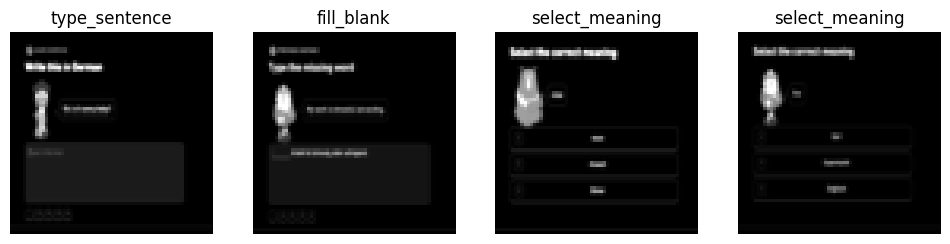

In [22]:
def show_batch(loader):
    images, labels = next(iter(loader))
    fig, ax = plt.subplots(1, 4, figsize=(12, 3))
    for i in range(4):
        ax[i].imshow(images[i][0], cmap='gray')
        ax[i].set_title(dataset.classes[labels[i]])
        ax[i].axis('off')
    plt.show()

show_batch(train_loader)


In [23]:
torch.save(model.state_dict(), "duolingo_cnn.pth")
